# Machine Learning on gut microbiota of patients with Colorectal cancer (8): Comparison between different classifiers

There are standard workflows in a machine learning project that can be automated. In Python scikit-learn, Pipelines help to clearly define and automate these workflows.
* Pipelines help overcome common problems like data leakage in your test harness. 
* Python scikit-learn provides a Pipeline utility to help automate machine learning workflows.
* Pipelines work by allowing for a linear sequence of data transforms to be chained together culminating in a modeling process that can be evaluated.

## Loading libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a pipeline that standardizes the data then creates a model
#Load libraries for data processing
import pandas as pd 
import numpy as np
from scipy.stats import norm

from sklearn.model_selection import train_test_split, KFold
#from sklearn.cross_validation import cross_val_score, KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# visualization
import seaborn as sns 
plt.style.use('fivethirtyeight')
sns.set_style("white")

plt.rcParams['figure.figsize'] = (8,4) 
#plt.rcParams['axes.titlesize'] = 'large'

## Importing data

In [2]:
'''
# raw data
data_df = pd.read_table('./dataset/MergeData.tsv', sep="\t", index_col=0)
data = data_df.reset_index(drop=True)
data.head()

# CLR-transformed data
data_df = pd.read_table('./dataset/MergeData_clr.tsv', sep="\t", index_col=0)
data = data_df.reset_index(drop=True)
data.head()
'''

# significant species
data_df = pd.read_table('./dataset/MergeData_clr_signif.tsv', sep="\t", index_col=0)
data = data_df.reset_index(drop=True)
data.head()

,disease,s__Parvimonas_micra,s__Roseburia_faecis,s__Collinsella_aerofaciens,s__Actinomyces_sp_HMSC035G02,s__Roseburia_intestinalis,s__Bacteroides_plebeius,s__Faecalibacterium_prausnitzii,s__Eubacterium_eligens,s__Ruminococcus_bicirculans,...,s__Bacteroides_caccae,s__Alistipes_shahii,s__Fusobacterium_mortiferum,s__Bacteroides_dorei,s__Bifidobacterium_pseudocatenulatum,s__Blautia_wexlerae,s__Haemophilus_parainfluenzae,s__Turicimonas_muris,s__Gemella_haemolysans,s__Bifidobacterium_longum
0,healthy,-3.441779,-3.441779,6.576766,-3.441779,-3.441779,10.262146,7.729839,7.605931,-3.441779,...,-3.441779,0.667517,-3.441779,8.532694,-3.441779,6.386041,4.686443,-3.441779,-3.441779,6.717971
1,healthy,-3.929140,5.691656,4.532923,-3.929140,6.393962,7.609333,6.654823,4.236672,4.372945,...,3.844374,1.704619,-3.929140,4.466872,3.229868,2.122180,2.479674,-3.929140,-3.929140,4.429797
2,healthy,-0.407520,7.383588,-3.379905,1.248080,3.614452,8.411267,7.668467,-3.379905,5.890776,...,5.935044,3.038147,-3.379905,7.884081,-3.379905,7.163770,2.015644,-3.379905,2.332939,-3.379905
3,healthy,-3.632294,5.307481,5.897842,-3.632294,3.636733,6.261269,5.819509,4.064784,-3.632294,...,-3.632294,3.401043,3.295942,6.939669,1.234944,3.370701,-3.632294,-3.632294,-3.632294,3.089479
4,CRC,2.320322,-5.007660,4.759592,-1.450665,-5.007660,-0.026692,3.808831,4.253082,2.034727,...,-5.007660,5.167885,-5.007660,5.697435,1.727297,2.949174,2.203556,-5.007660,0.273296,3.893588


## Evaluate Some Algorithms
Now it is time to create some models of the data and estimate their accuracy on unseen data. Here is what we are going to cover in this step:
1. Separate out a validation dataset.
2. Setup the test harness to use 10-fold cross validation.
3. Build 5 different models  
4. Select the best model

## Validation Dataset

In [3]:
# Split-out validation dataset
array = data.values
X = array[:, 1:data.shape[1]]
y = array[:, 0]

# Divide records in training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

#transform the class labels from their original string representation (CRC and healthy) into integers
le = LabelEncoder()
y = le.fit_transform(y)

## Evaluate Algorithms: Baseline

In [4]:
# turn off warnings
import warnings

def action_with_warnings():
    warnings.warn("forbid warnings' display")

with warnings.catch_warnings(record=True):
    action_with_warnings()

# Spot-Check Algorithms
models = []
models.append(( 'LR' , LogisticRegression()))
models.append(( 'LDA' , LinearDiscriminantAnalysis()))
models.append(( 'KNN' , KNeighborsClassifier()))
models.append(( 'CART' , DecisionTreeClassifier()))
models.append(( 'NB' , GaussianNB()))
models.append(( 'SVM' , SVC()))

# Test options and evaluation metric
num_folds = 10
num_instances = len(X_train)
seed = 7 
scoring =  'accuracy'

# Test options and evaluation metric
num_folds = 10
num_instances = len(X_train)
seed = 7 
scoring = 'accuracy'
results = []
names = []
for name, model in models:
    #kfold = KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X=X_train, y=y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
print('-> 10-Fold cross-validation accurcay score for the training data for six classifiers') 

LR: 0.682063 (0.099066)
LDA: 0.684921 (0.101168)
KNN: 0.585079 (0.080096)
CART: 0.616825 (0.057095)
NB: 0.690873 (0.105033)
SVM: 0.679286 (0.076846)
-> 10-Fold cross-validation accurcay score for the training data for six classifiers


### Observation
> The results suggest That both GaussianNB and SVM may be worth further study. These are just mean accuracy values. It is always wise to look at the distribution of accuracy values calculated across cross validation folds. We can do that graphically using box and whisker plots.


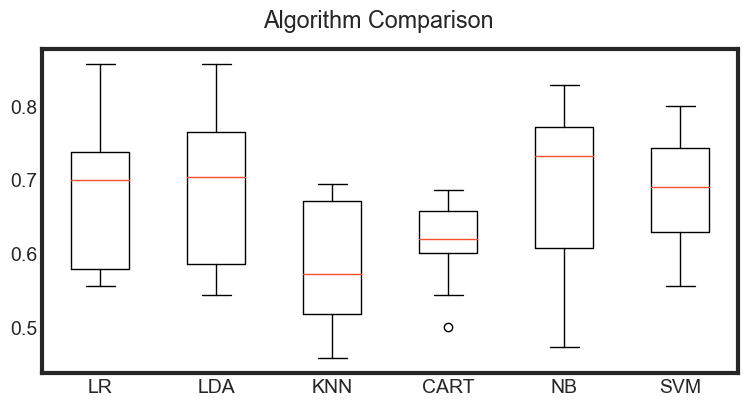

In [5]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison' )
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Observation
> The results show a similar tight distribution for all classifiers except KNN which is encouraging, suggesting low variance.

> It is possible the varied distribution of the attributes may have an effect on the accuracy of algorithms such as LR, LDA and KNN. In the next section we will repeat this spot-check with a standardized copy of the training dataset.


### Evaluate Algorithms: Standardize Data

In [6]:
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),( 'LR' ,
    LogisticRegression())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),( 'LDA' ,
    LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledKNN' , Pipeline([( 'Scaler' , StandardScaler()),( 'KNN' ,
    KNeighborsClassifier())])))
pipelines.append(( 'ScaledCART' , Pipeline([( 'Scaler' , StandardScaler()),( 'CART' ,
    DecisionTreeClassifier())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),( 'NB' ,
    GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),( 'SVM' , SVC())])))

results = []
names = []
for name, model in pipelines:
    #kfold = KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.682063 (0.099066)
ScaledLDA: 0.684921 (0.101168)
ScaledKNN: 0.585476 (0.076252)
ScaledCART: 0.622222 (0.066893)
ScaledNB: 0.690873 (0.105033)
ScaledSVM: 0.687619 (0.085907)


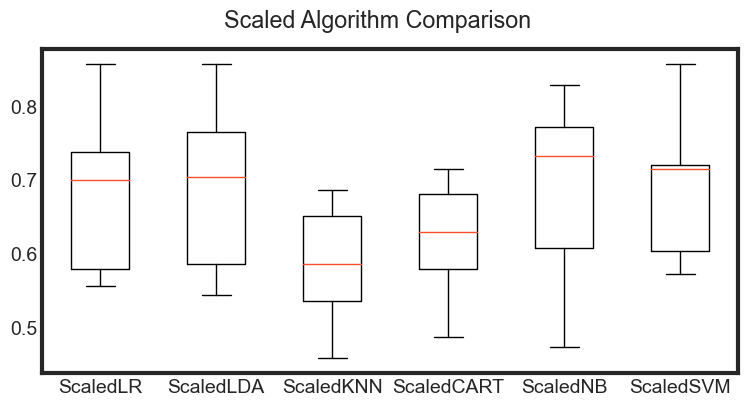

In [7]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle( 'Scaled Algorithm Comparison' )
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Observations
> The results show that standardization of the data has lifted the skill of SVM to be the most accurate algorithm tested so far.

The results suggest digging deeper into the SVM and LDA and LR algorithms. It is very likely that configuration beyond the default may yield even more accurate models.

## Algorithm Tuning
In this section we investigate tuning the parameters for three algorithms that show promise from the spot-checking in the previous section: LR, LDA and SVM.

### Tuning hyper-parameters - SVC estimator

In [8]:
# turn off warnings
import warnings

def action_with_warnings():
    warnings.warn("forbid warnings' display")

with warnings.catch_warnings(record=True):
    action_with_warnings()

#Make Support Vector Classifier Pipeline
pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA(n_components=2)),
                     ('clf', SVC(probability=True, verbose=False))])

#Fit Pipeline to training Data
pipe_svc.fit(X_train, y_train)

#print('--> Fitted Pipeline to training Data')

scores = cross_val_score(estimator=pipe_svc, X=X_train, y=y_train, cv=10, n_jobs=1, verbose=0)
print('--> Model Training Accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

#Tune Hyperparameters
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,'clf__kernel': ['linear']},
              {'clf__C': param_range,'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs_svc = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=1)
gs_svc = gs_svc.fit(X_train, y_train)
print('--> Tuned Parameters Best Score: ', gs_svc.best_score_)
print('--> Best Parameters: \n', gs_svc.best_params_)

--> Model Training Accuracy: 0.633 +/- 0.094
--> Tuned Parameters Best Score:  0.6533333333333333
--> Best Parameters: 
 {'clf__C': 10.0, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}


### Tuning the hyper-parameters - k-NN hyperparameters
 For your standard k-NN implementation, there are two primary hyperparameters that you’ll want to tune:

* The number of neighbors k.
* The distance metric/similarity function.

Both of these values can dramatically affect the accuracy of your k-NN classifier. Grid object is ready to do 10-fold cross validation on a KNN model using classification accuracy as the evaluation metric
In addition, there is a parameter grid to repeat the 10-fold cross validation process 30 times
Each time, the n_neighbors parameter should be given a different value from the list
We can't give GridSearchCV just a list
We've to specify n_neighbors should take on 1 through 30
You can set n_jobs = -1 to run computations in parallel (if supported by your computer and OS) 

In [9]:
from sklearn.neighbors import KNeighborsClassifier as KNN

pipe_knn = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA(n_components=2)),
                     ('clf', KNeighborsClassifier())])
            
#Fit Pipeline to training Data
pipe_knn.fit(X_train, y_train) 

scores = cross_val_score(estimator=pipe_knn, 
                         X=X_train, 
                         y=y_train, 
                         cv=10,
                         n_jobs=1)
print('--> Model Training Accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

#Tune Hyperparameters
param_range = range(1, 31)
param_grid = [{'clf__n_neighbors': param_range}]
# instantiate the grid
grid = GridSearchCV(estimator=pipe_knn, 
                    param_grid=param_grid, 
                    cv=10, 
                    scoring='accuracy')
gs_knn = grid.fit(X_train, y_train)
print('--> Tuned Parameters Best Score: ', gs_knn.best_score_)
print('--> Best Parameters: \n', gs_knn.best_params_)

--> Model Training Accuracy: 0.590 +/- 0.108
--> Tuned Parameters Best Score:  0.6558730158730158
--> Best Parameters: 
 {'clf__n_neighbors': 17}


## Finalize Model

In [10]:
#Use best parameters
clf_svc = gs_knn.best_estimator_

#Get Final Scores
clf_svc.fit(X_train, y_train)
scores = cross_val_score(estimator=clf_svc,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('--> Final Model Training Accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

print('--> Final Accuracy on Test set: %.5f' % clf_svc.score(X_test,y_test))


--> Final Model Training Accuracy: 0.656 +/- 0.097
--> Final Accuracy on Test set: 0.53947


In [11]:
clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5394736842105263
[[40 46]
 [24 42]]
              precision    recall  f1-score   support

         CRC       0.62      0.47      0.53        86
     healthy       0.48      0.64      0.55        66

    accuracy                           0.54       152
   macro avg       0.55      0.55      0.54       152
weighted avg       0.56      0.54      0.54       152



## Summary

Worked through a classification predictive modeling machine learning problem from end-to-end using Python. Specifically, the steps covered were:
1. Problem Definition.
2. Loading the Dataset.
3. Analyze Data (same scale but different distributions of data).
    * Evaluate Algorithms (KNN looked good).
    * Evaluate Algorithms with Standardization (KNN and SVM looked good).
4. Algorithm Tuning (K=19 for KNN was good, SVM with an RBF kernel and C=100 was best).. 
5. Finalize Model (use all training data and confirm using validation dataset)

## Reference

* [Breast-cancer-risk-prediction](https://github.com/Jean-njoroge/Breast-cancer-risk-prediction)